# ELE510 Project - Hand Gesture Detection

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import codecs
import json
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Hide GPU due to small model
tf.config.set_visible_devices([], 'GPU')

## Loading and testing data

Each image has a an annotation. The annotation consists of the fields: `bboxes`, `labels`, `landmarks`, `leading_conf`, `leading_hand`, and `user_id`. <br>
<br>
bboxes - Normalized coordinates for boxes around detected hands. `[top left X pos, top left Y pos, width, height]`. <br>
labels - List of class labels of the detected gestures. e.g. `like`, `peace`, `no_gesture`. <br>
landmarks - List of normalized hand landmarks `[x, y]`. <br>
leading_conf - Leading confidence for `leading_hand`.  <br>
leading_hand - `right` or `left` for hand which showing gesture. <br>
user_id - subject id.

In [2]:
# Adding all annotation files to a list
files = []
for file in os.listdir("data"):
    if file.endswith(".json"):
        files.append(os.path.join("data", file))
        
# Exporting json data from file to dictionary
class_names = [
       'call',
       'dislike',
       'fist',
       'four',
       'like',
       'mute',
       'ok',
       'one',
       'palm',
       'peace',
       'peace_inverted',
       'rock',
       'stop',
       'stop_inverted',
       'three',
       'three2',
       'two_up',
       'two_up_inverted']

data = {}

classindex = 0
for file in files:
    current_class = class_names[classindex]
    class_annotations = {}
    with codecs.open(file,'r','utf-8') as f: 
        annotations = json.load(f)
        for annotation in annotations:
            class_annotations[annotation] = annotations[annotation]
    classindex += 1
    data[current_class] = class_annotations

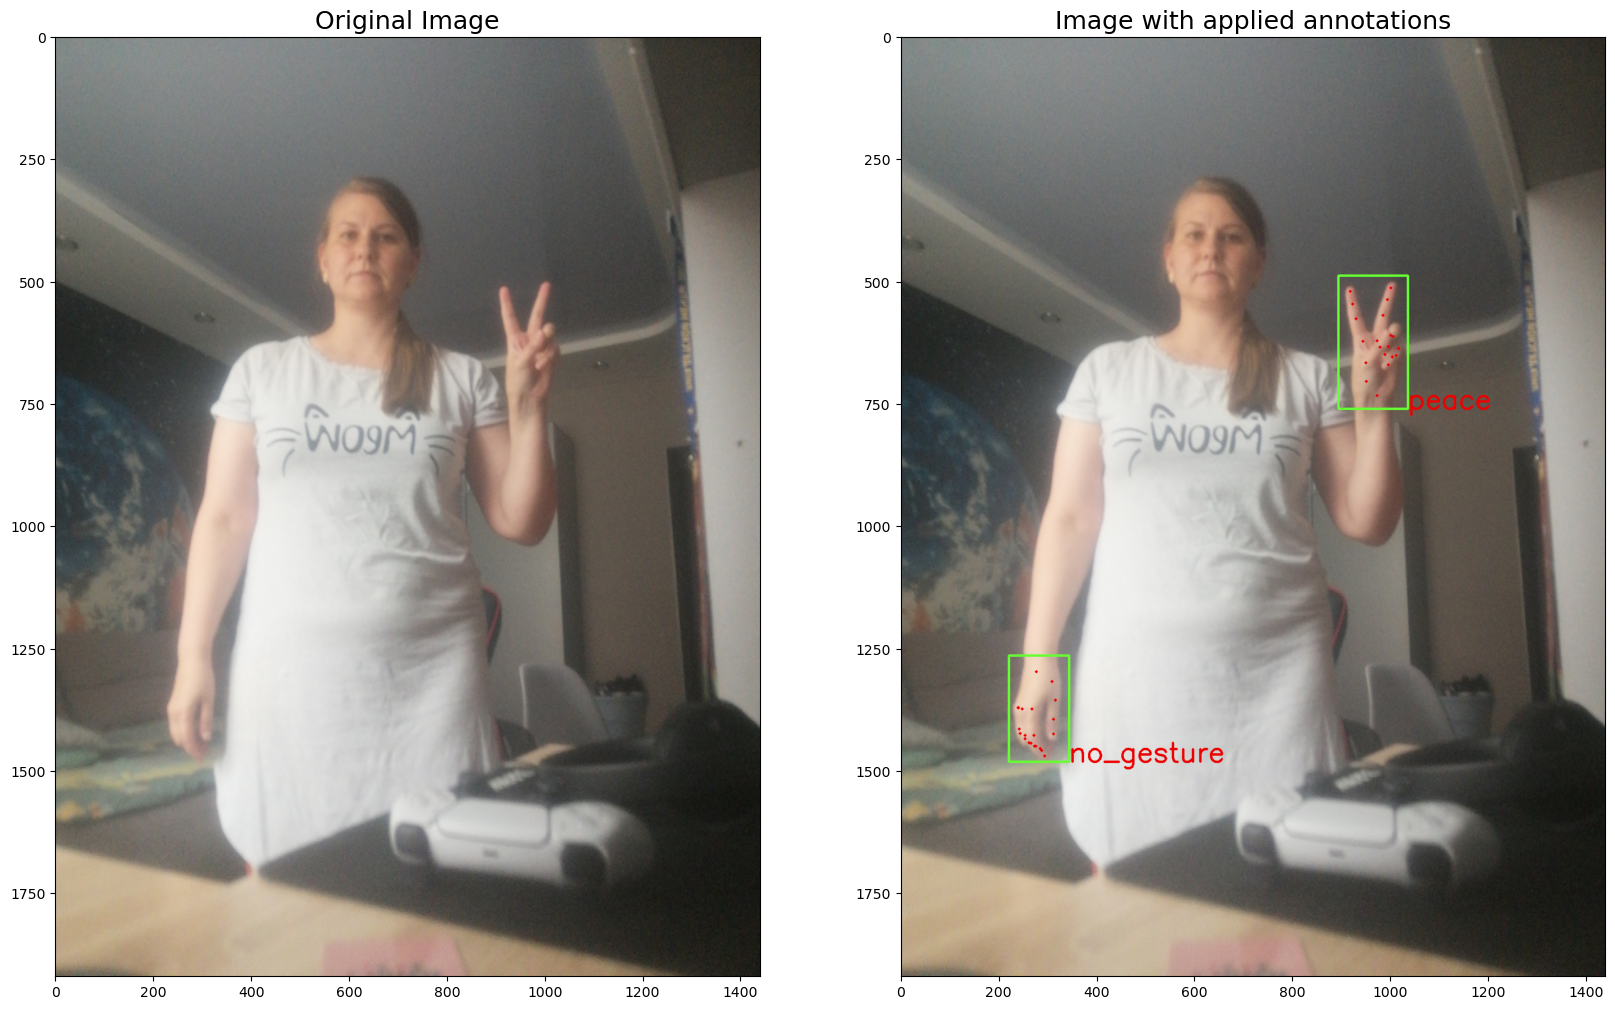

In [3]:
# Testing data in RGB format
image_name = '046a2bea-e479-4ec2-9fa9-05d5a1e96755'
im = cv2.imread('images/original/peace/' + image_name + '.jpg')[...,::-1]

# Applying image annotations
im_ann = im.copy()
im_data = data['peace'][image_name]
h, w = im_ann.shape[0], im_ann.shape[1]
iteration = 0
for bbox in im_data['bboxes']:
    start_point = (int(w*bbox[0]) , int(h*bbox[1]))
    end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
    im_ann = cv2.rectangle(im_ann, start_point, end_point, color = (102,255,51), thickness = 3)
    cv2.putText(im_ann, im_data['labels'][iteration], (end_point[0], end_point[1]), cv2.FONT_HERSHEY_SIMPLEX, w / 780, (237, 0, 0), 3)
    iteration += 1

for landmark in im_data['landmarks']:
    for coordinate in landmark:
        im_ann = cv2.circle(im_ann, (int(w*coordinate[0]), int(h*coordinate[1])), radius=1, color=(237, 0, 0), thickness=3)
    
# Plot images
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Original Image', fontsize=18)
plt.imshow(im)
plt.subplot(122)
plt.title('Image with applied annotations', fontsize=18)
plt.imshow(im_ann)
plt.show()

## Image preprocessing

When having a small dataset the model will sometimes learn from noises or unwanted details from training examples, to an extent that it negatively impacts the performance of the model on new examples. Also known as overfitting. To avoid this we would normally preprocess the images. <br> 
<br>
Preprocessing steps:
1. Create a depth map of the image. <br>
2. Use depth thresholding and remove noise to localize hand in depth map. <br>
3. Resize the hand segment according to the model input size. <br>
<br>
For this dataset the preprocessing is already done in the annotation files. We create new images out of the areas inside `bboxes` for training the model.

In [4]:
# Defining height and width for new images as well as input for the model
img_height = 300
img_width = 300

# Crop and resize images
for category in class_names:
    for img_name in data[category]:
        im = cv2.imread('images/original/' + category + '/' + img_name + '.jpg', cv2.IMREAD_GRAYSCALE)
        h, w = im.shape[0], im.shape[1]
        iteration = 0
        for bbox in data[category][img_name]['bboxes']:
            start_point = (int(w*bbox[0]) , int(h*bbox[1]))
            end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
            cropped_image = im[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            resized_image = cv2.resize(cropped_image, (img_height, img_width), interpolation= cv2.INTER_LINEAR)
            label = data[category][img_name]['labels'][iteration]
            cv2.imwrite('images/preprocessed/' + label + '/' + img_name + '.jpg' , resized_image)
            iteration += 1

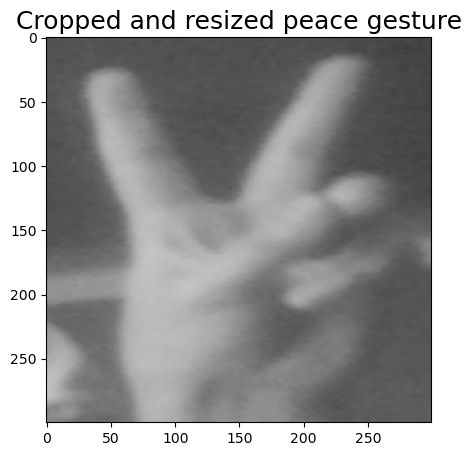

In [43]:
# Preprocessed image from example above
cropped_im_1 = cv2.imread('images/preprocessed/peace/' + image_name + '.jpg')

plt.figure(figsize=(5,5))
plt.title('Cropped and resized peace gesture', fontsize=18)
plt.imshow(cropped_im_1)
plt.show()

## Create train and validation dataset using the 80/20 split

In [72]:
# Defining parameters for loader
img_height = 300
img_width = 300
batch_size = 32

# Creating train dataset
train_data = tf.keras.utils.image_dataset_from_directory(
  'images/preprocessed',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Creating test dataset
validation_data = tf.keras.utils.image_dataset_from_directory(
  'images/preprocessed',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1800 files belonging to 18 classes.
Using 1440 files for training.
Found 1800 files belonging to 18 classes.
Using 360 files for validation.


## Create and compile model

In [73]:
# Creating model
num_classes = len(validation_data.class_names)

# Data augmentation to replicate more data
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ])

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

# Compiling model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 300, 300, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                

## Train model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 50
history = model.fit(train_data, validation_data=validation_data, epochs=epochs)

Epoch 1/50
45/45 [==============================] - 57s 1s/step - loss: 2.9129 - accuracy: 0.0576 - val_loss: 2.8887 - val_accuracy: 0.0778
Epoch 2/50
45/45 [==============================] - 59s 1s/step - loss: 2.8859 - accuracy: 0.0750 - val_loss: 2.8849 - val_accuracy: 0.0750
Epoch 3/50
45/45 [==============================] - 61s 1s/step - loss: 2.8586 - accuracy: 0.1063 - val_loss: 2.7873 - val_accuracy: 0.1056
Epoch 4/50
45/45 [==============================] - 63s 1s/step - loss: 2.7394 - accuracy: 0.1472 - val_loss: 2.6544 - val_accuracy: 0.1528
Epoch 5/50
45/45 [==============================] - 59s 1s/step - loss: 2.5889 - accuracy: 0.1979 - val_loss: 2.3859 - val_accuracy: 0.2778
Epoch 6/50
45/45 [==============================] - 62s 1s/step - loss: 2.4202 - accuracy: 0.2660 - val_loss: 2.1591 - val_accuracy: 0.3222
Epoch 7/50
45/45 [==============================] - 69s 2s/step - loss: 2.2707 - accuracy: 0.2854 - val_loss: 1.9857 - val_accuracy: 0.4056
Epoch 8/50
45/45 [==

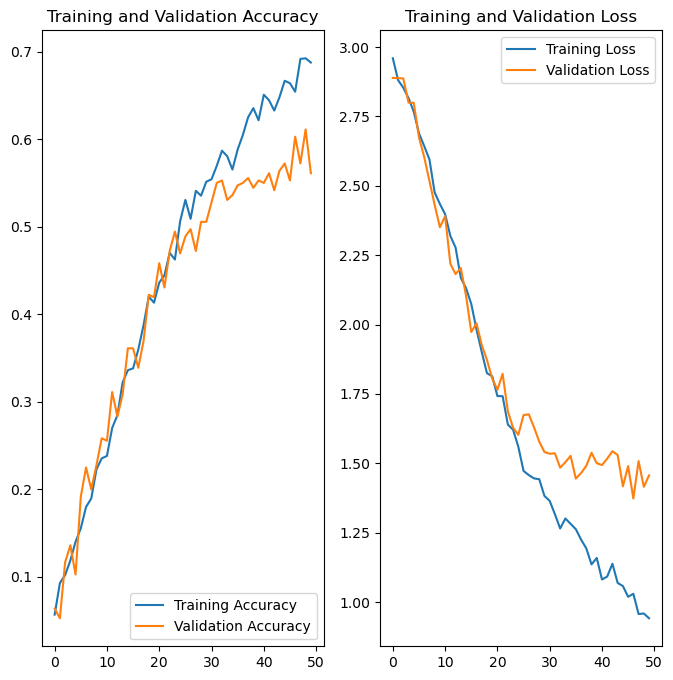

In [39]:
# Vizualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Save model
model.save('tf_model/')

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


## Test model

In [54]:
# Load model
model = keras.models.load_model('tf_model')

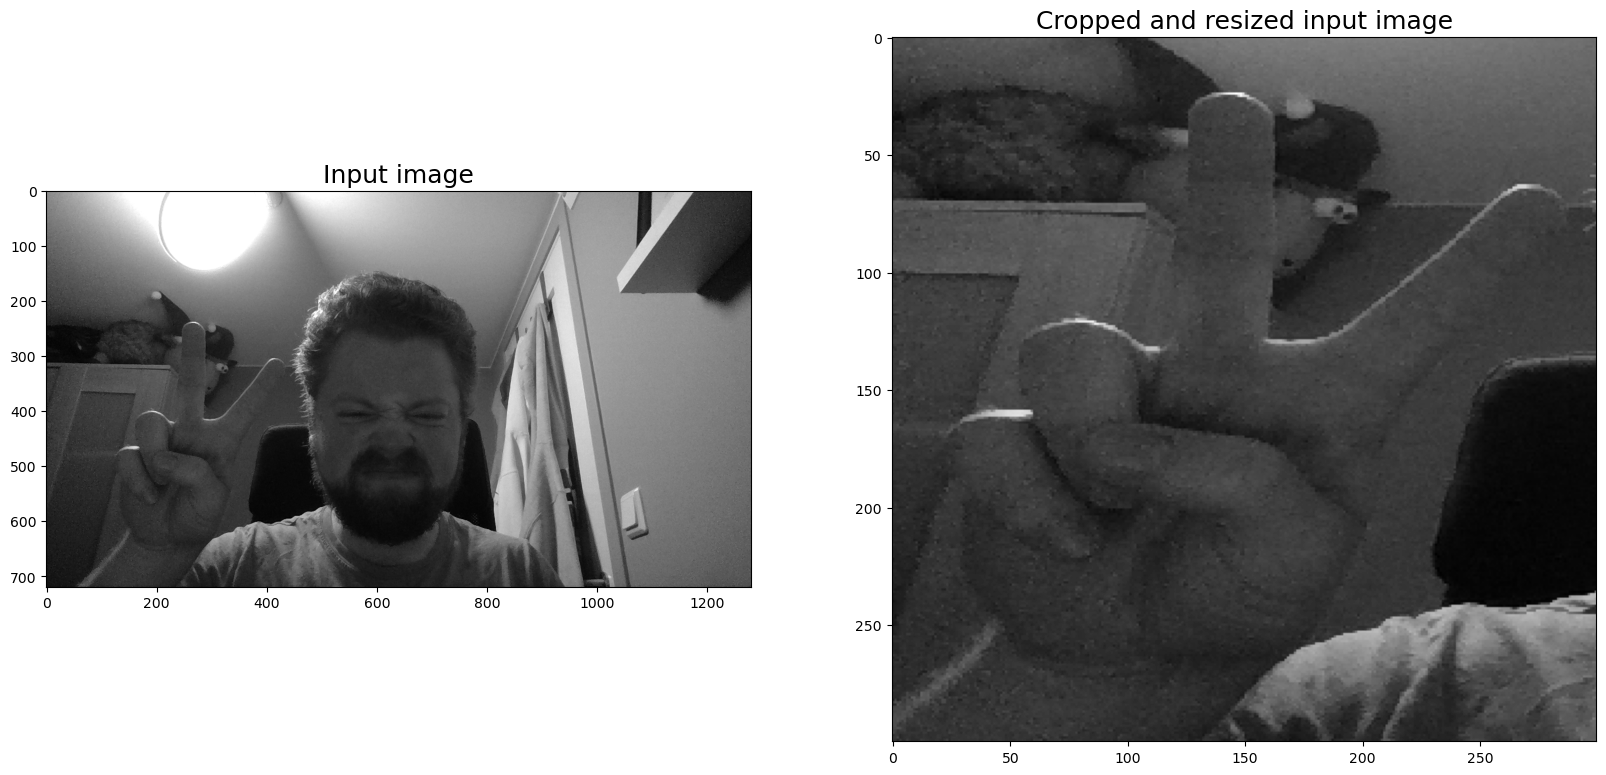

In [40]:
# Preprocess input image
# TODO: Find hand
input_image = cv2.imread('test.jpg', cv2.IMREAD_GRAYSCALE)
cropped_input_image = input_image[200:700, 100:450]
cropped_input_image = cv2.resize(cropped_input_image, (300, 300), interpolation= cv2.IMREAD_GRAYSCALE)

cv2.imwrite('test_crop.jpg', cropped_input_image)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Input image', fontsize=18)
plt.imshow(input_image, cmap = 'gray')
plt.subplot(122)
plt.title('Cropped and resized input image', fontsize=18)
plt.imshow(cropped_input_image, cmap = 'gray')
plt.show()

1/1 [==============================] - 0s 27ms/step


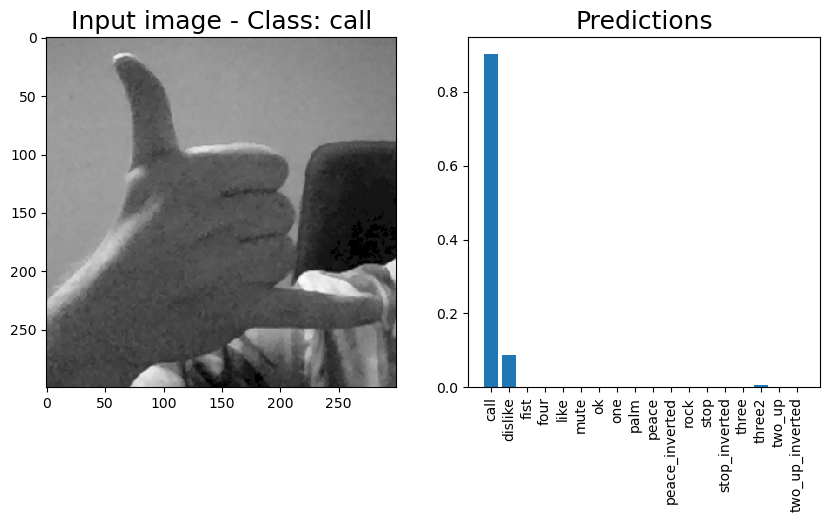

This image most likely belongs to call with a 90.26 percent confidence.
1/1 [==============================] - 0s 30ms/step


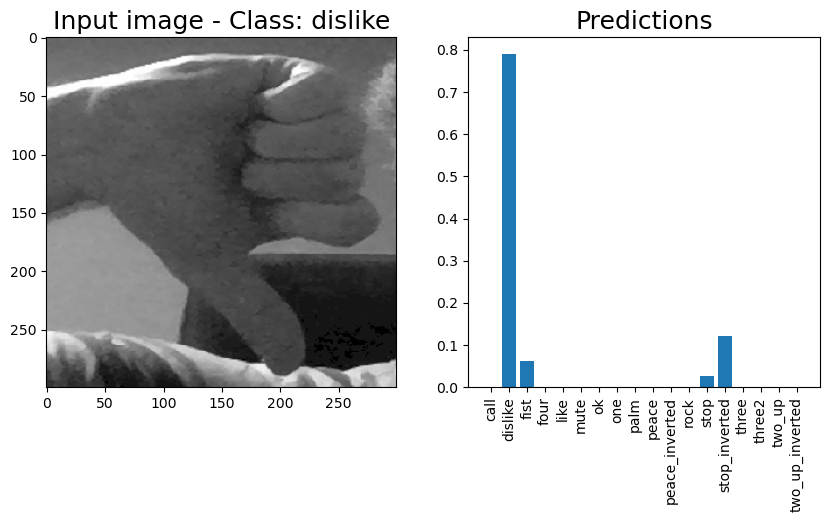

This image most likely belongs to dislike with a 79.03 percent confidence.
1/1 [==============================] - 0s 27ms/step


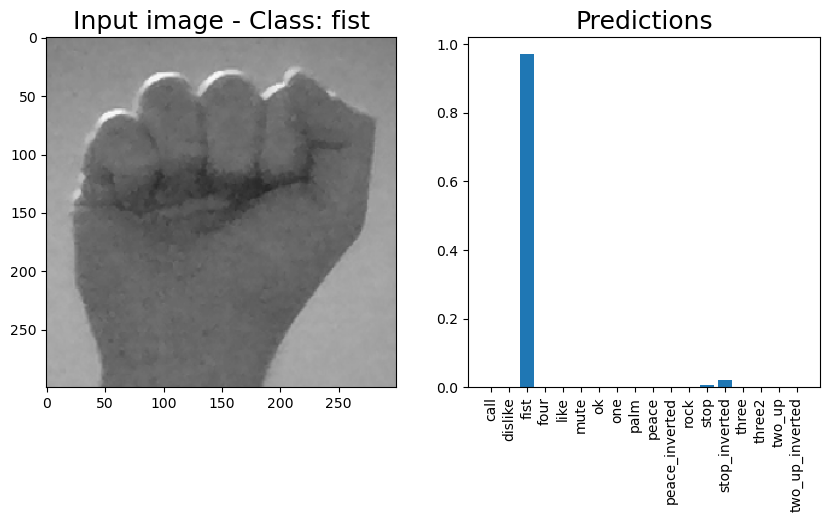

This image most likely belongs to fist with a 97.09 percent confidence.
1/1 [==============================] - 0s 25ms/step


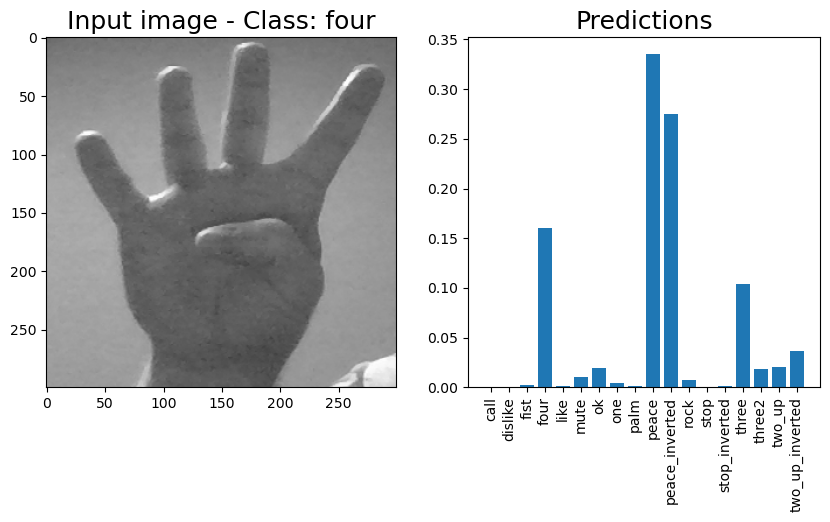

This image most likely belongs to peace with a 33.54 percent confidence.
1/1 [==============================] - 0s 24ms/step


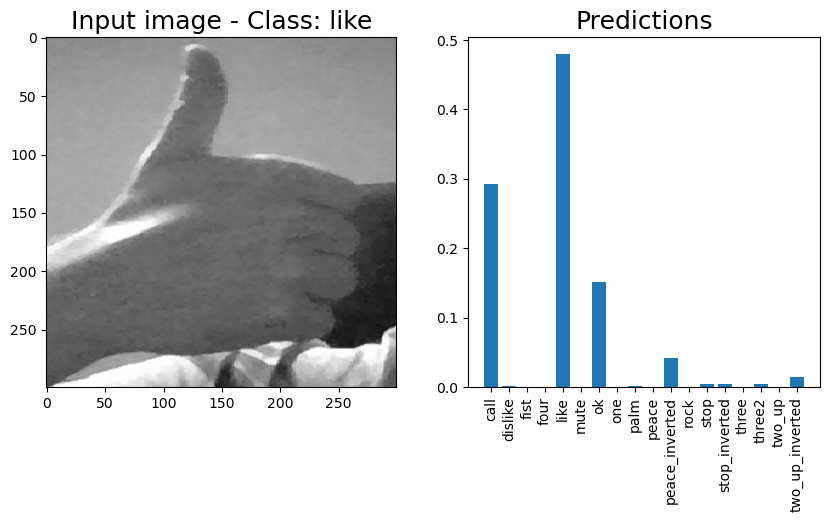

This image most likely belongs to like with a 47.99 percent confidence.
1/1 [==============================] - 0s 24ms/step


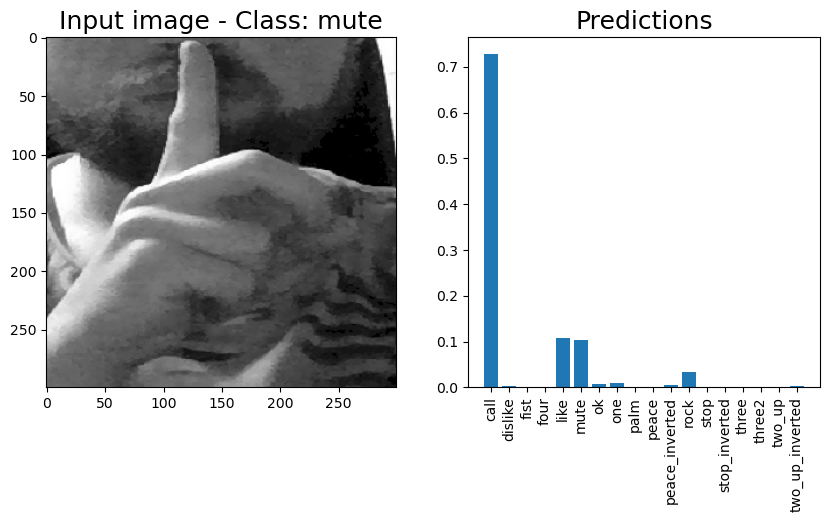

This image most likely belongs to call with a 72.82 percent confidence.
1/1 [==============================] - 0s 28ms/step


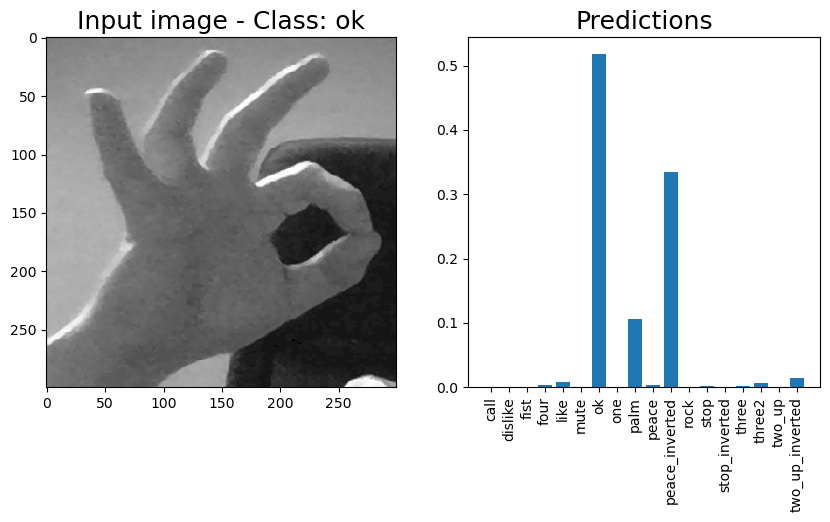

This image most likely belongs to ok with a 51.80 percent confidence.
1/1 [==============================] - 0s 30ms/step


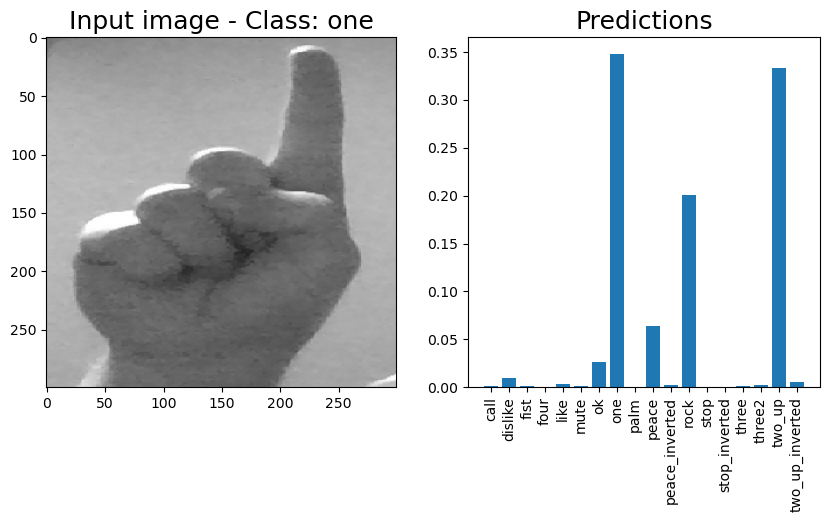

This image most likely belongs to one with a 34.80 percent confidence.
1/1 [==============================] - 0s 24ms/step


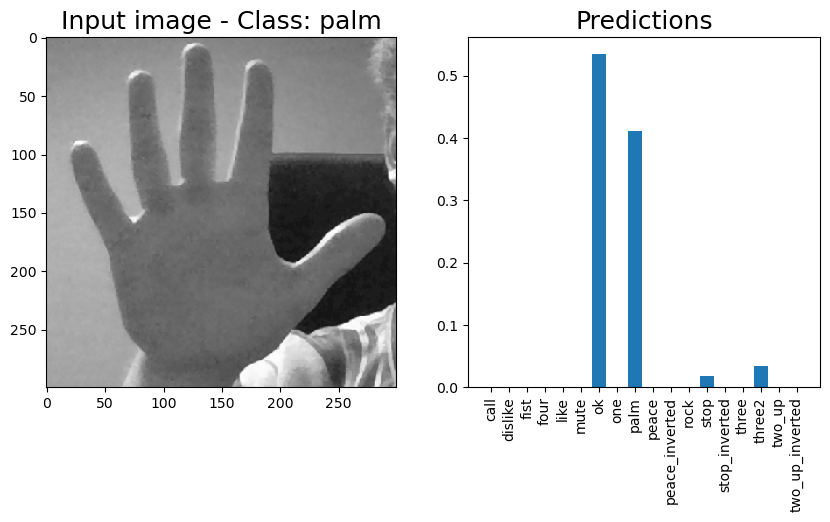

This image most likely belongs to ok with a 53.53 percent confidence.
1/1 [==============================] - 0s 24ms/step


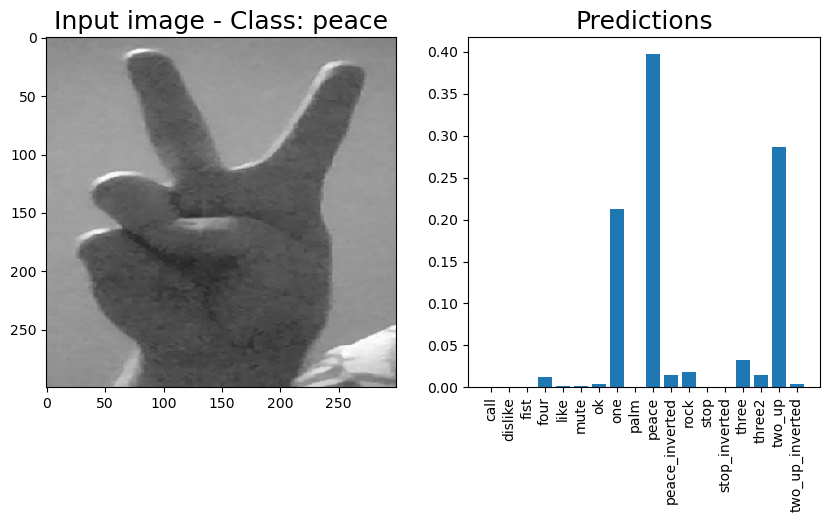

This image most likely belongs to peace with a 39.76 percent confidence.
1/1 [==============================] - 0s 23ms/step


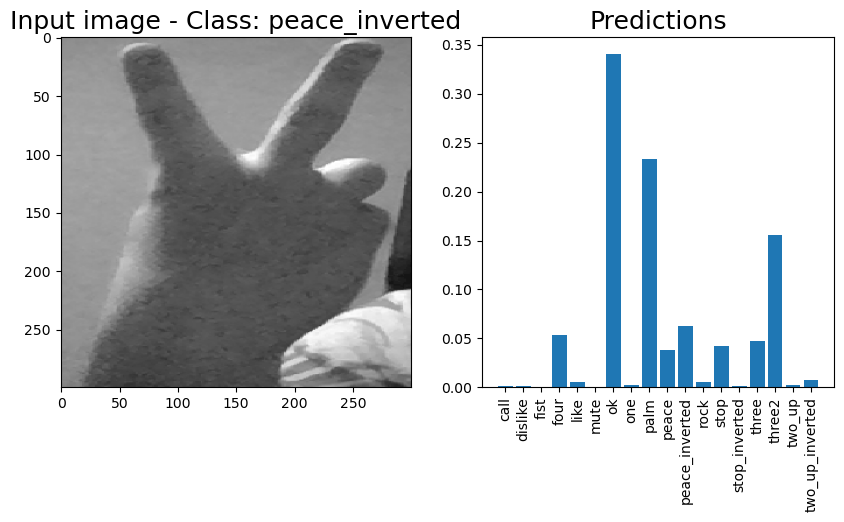

This image most likely belongs to ok with a 34.07 percent confidence.
1/1 [==============================] - 0s 23ms/step


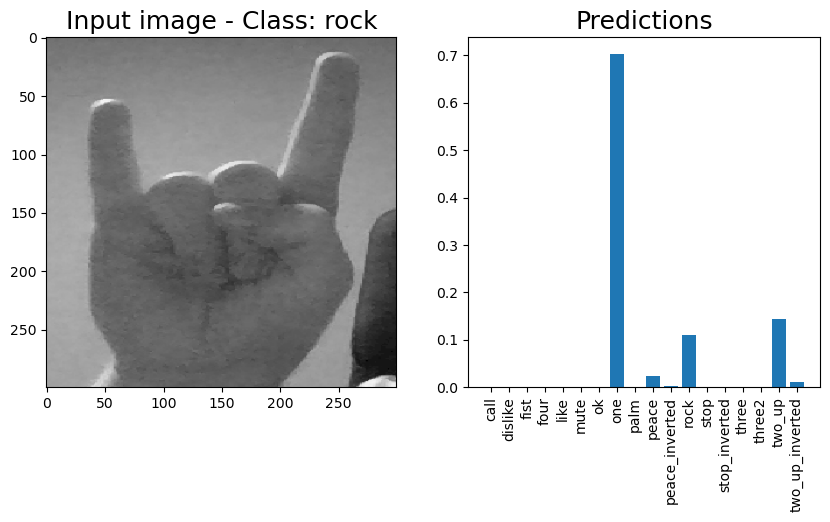

This image most likely belongs to one with a 70.31 percent confidence.
1/1 [==============================] - 0s 24ms/step


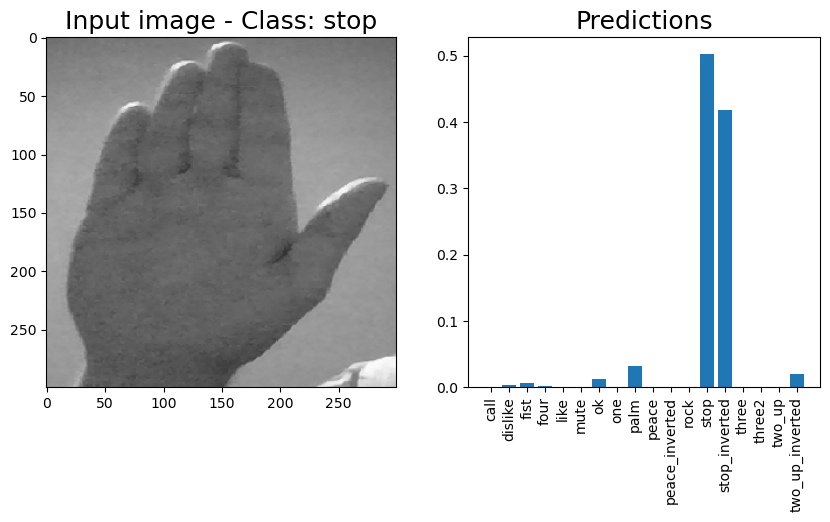

This image most likely belongs to stop with a 50.29 percent confidence.
1/1 [==============================] - 0s 23ms/step


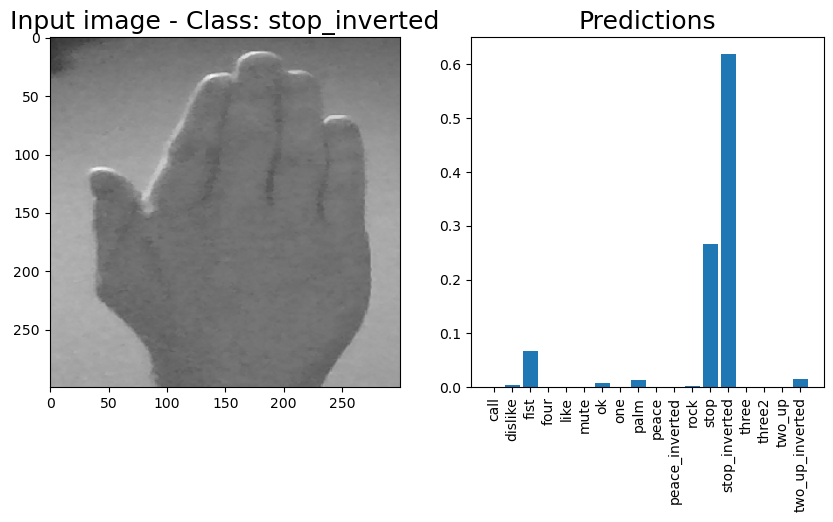

This image most likely belongs to stop_inverted with a 61.94 percent confidence.
1/1 [==============================] - 0s 23ms/step


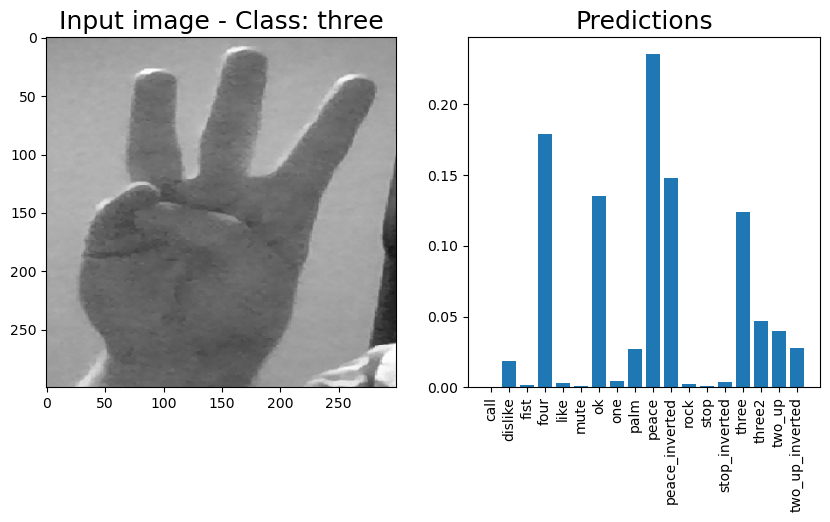

This image most likely belongs to peace with a 23.55 percent confidence.
1/1 [==============================] - 0s 25ms/step


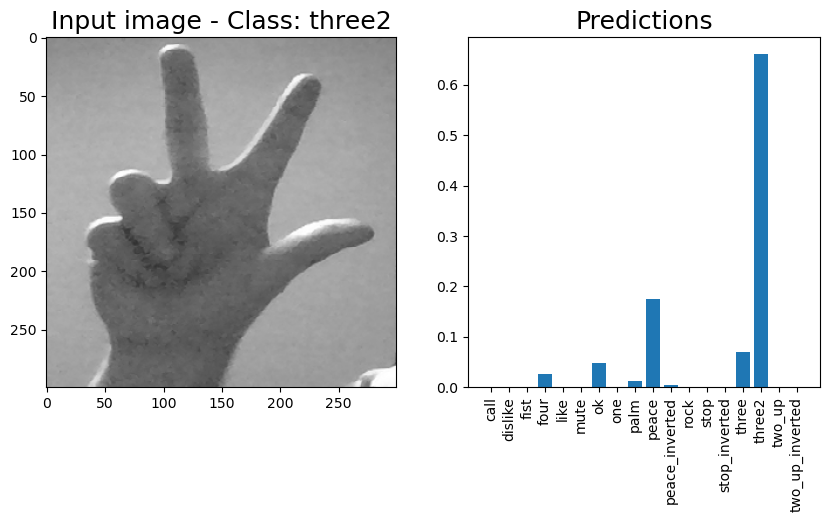

This image most likely belongs to three2 with a 66.13 percent confidence.
1/1 [==============================] - 0s 26ms/step


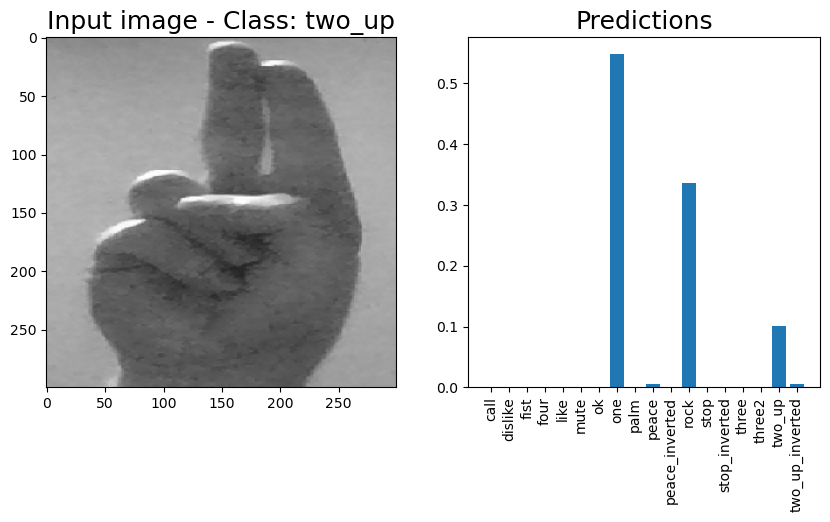

This image most likely belongs to one with a 54.86 percent confidence.
1/1 [==============================] - 0s 25ms/step


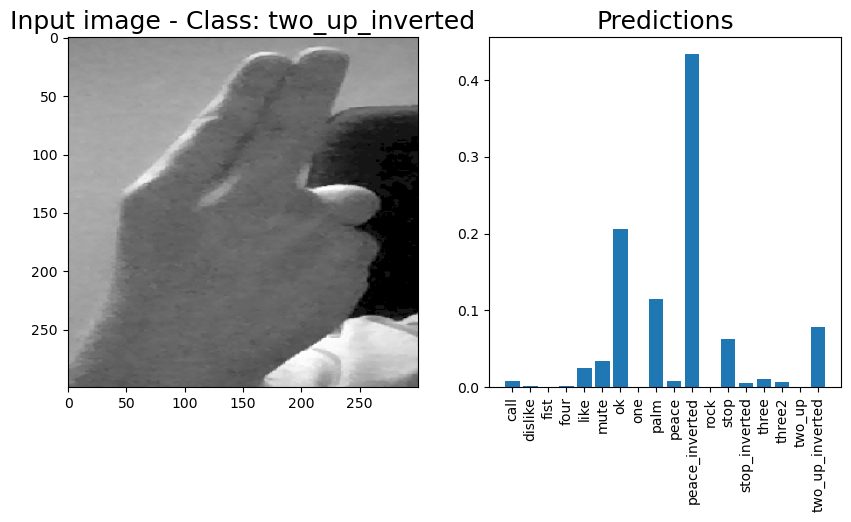

This image most likely belongs to peace_inverted with a 43.41 percent confidence.


In [67]:
# Test set of input images
for name in class_names:
    img = tf.keras.utils.load_img('images/test/' + name + '.png', target_size=(300, 300))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    class_names = train_data.class_names
    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title('Input image - Class: ' + name, fontsize=18)
    plt.imshow(img, cmap = 'gray')
    plt.subplot(222)
    plt.title('Predictions', fontsize=18)
    plt.bar(class_names, score)
    plt.xticks(range(len(class_names)), class_names, rotation=90)

    plt.show()

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

